# Importing Libraries


In [ ]:
!pip install polars
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings(action="ignore")
from zipfile import ZipFile
sns.set_style("darkgrid")
sns.set_palette(palette=["gray", "red", "green"])
import random
import re

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

# Importing Dataset and Data Pre-Processing

In [3]:
df = pl.read_csv("Reviews.csv")
df = df.select("Score", "Text")
df.head()

Score,Text
i64,str
5,"""I have bought …"
1,"""Product arrive…"
4,"""This is a conf…"
2,"""If you are loo…"
5,"""Great taffy at…"


In [4]:
df.shape

(568454, 2)

In [5]:
df = df.drop_nulls()
df = df.unique(subset = "Text")

In [6]:
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text)

    return text.strip()

In [7]:
df = df.with_columns(clean_text = pl.col(["Text"]).apply(clean_text))

In [8]:
def get_sentiment(score): 
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [9]:
df = df.with_columns(length = pl.col("clean_text").apply(lambda x: len(str(x).split())),
                    sentiment = pl.col("Score").apply(get_sentiment))

df.head()

Score,Text,clean_text,length,sentiment
i64,str,str,i64,str
5,"""Bucatini is a …","""Bucatini is a …",41,"""Positive"""
3,"""This was not 1…","""This was not 1…",24,"""Neutral"""
4,"""This pink salt…","""This pink salt…",62,"""Positive"""
1,"""Yes, this comp…","""Yes, this comp…",21,"""Negative"""
1,"""Ordered this i…","""Ordered this i…",26,"""Negative"""


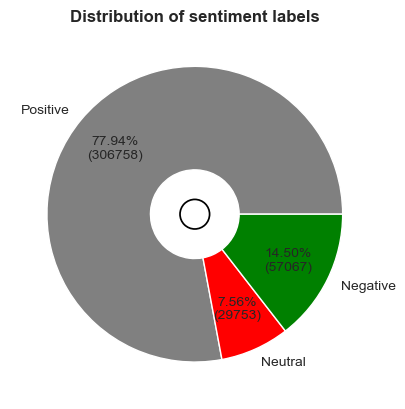

In [10]:
sentiment_counts = df.groupby("sentiment").count()

ax, *_ = plt.pie(
    x=sentiment_counts["count"], 
    labels=sentiment_counts["sentiment"],
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts["count"])/100)})', 
    wedgeprops=dict(width=0.7),
    textprops = dict(size=10),
    pctdistance = 0.7)

center_circle = plt.Circle((0, 0), 0.1, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of sentiment labels", weight="bold")
plt.show()

In [11]:
neu_df = df.filter(pl.col("sentiment") == "Neutral")
neg_df = df.filter(pl.col("sentiment") == "Negative")
pos_df = df.filter(pl.col("sentiment") == "Positive")
pos_df = pos_df.sample(len(neg_df))

df2 = pl.concat((neg_df, neu_df, pos_df), how="vertical")

In [12]:
del neu_df, neg_df, pos_df, df

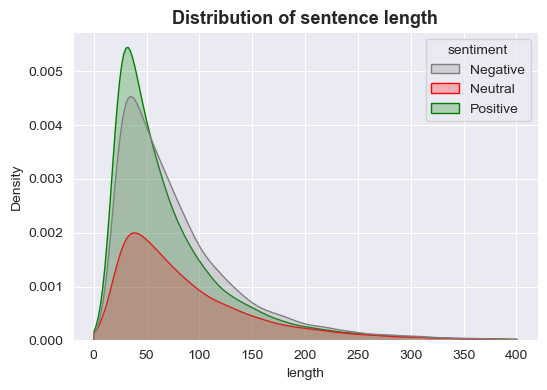

In [13]:
fig = plt.figure(figsize=(6, 4))
sns.kdeplot(data=df2.to_pandas(), x="length", shade=True, hue="sentiment", clip=[0, 400])
plt.title("Distribution of sentence length", size=13, weight="bold")
plt.show()

In [14]:
target = df2["sentiment"]
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Splitting Dataset

In [15]:
def split_data(X, y = None, *, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, seed=None):
    if train_ratio + test_ratio + validation_ratio != 1.0:
        raise ValueError("Ratios should add up to 1.0")

    total_length = len(X)
    train_size = int(train_ratio * total_length)
    test_size = int(test_ratio * total_length)

    if seed is not None:
        np.random.seed(seed)
    index = np.random.permutation(np.arange(total_length))
    X = np.array(X)[index]

    train_X = X[:train_size]
    test_X = X[train_size:train_size + test_size]
    validation_X = X[train_size + test_size:]

    if y is not None:
        y = y[index]
        train_y = y[:train_size]
        test_y = y[train_size:train_size + test_size]
        validation_y = y[train_size + test_size:]

        return (train_X, train_y), (test_X, test_y), (validation_X, validation_y)
    return train_X, test_X, validation_X

In [17]:

train_data, test_data, validation_data = split_data(
    df2["clean_text"],
    target,
    train_ratio=0.7,
    test_ratio=0.15,
    validation_ratio=0.15,
    seed=42)

In [18]:
max_tokens = 40000
seq_len = 200
batch_size = 64

feature_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=seq_len,
    encoding='utf-8',)

feature_vectorizer.adapt(train_data[0])

In [19]:
X_train = feature_vectorizer(train_data[0])
X_test = feature_vectorizer(test_data[0])
X_valid = feature_vectorizer(validation_data[0])

y_train = train_data[1]
y_test = test_data[1]
y_valid = validation_data[1]

In [20]:
del train_data, target, validation_data

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

train_ds = train_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [22]:
for inputs, target in train_ds.take(1).as_numpy_iterator():
    for i in range(2):
        print(tf.shape(inputs[i]))
        print()
        print("Inputs:", inputs[i, :20])
        print("Target:", target[i])

tf.Tensor([200], shape=(1,), dtype=int32)

Inputs: [ 269   26 1930 3968  707    7 2043    6 1442  521  536    9 1426   50
   99  149 3090    5   49    8]
Target: 0
tf.Tensor([200], shape=(1,), dtype=int32)

Inputs: [  99   44  157    8 1433  310  177   19   12    2  150  478  395   32
   42    3   75   13 1433  310]
Target: 1


# Model Building

In [23]:
class TransformerBlock(layers.Layer):
    def __init__(self, emb_dim, num_heads, ff_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.attention = layers.MultiHeadAttention(self.num_heads, self.emb_dim,)
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.fc = layers.Dense(self.ff_dim, activation="relu")
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        att_outputs = self.attention(inputs, inputs)
        att_outputs = self.dropout(att_outputs)
        x = self.layer_norm1(inputs+att_outputs)
        fc_output = self.fc(x)
        return self.layer_norm2(x + fc_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embedding_dim": self.emb_dim,
            "num_heads": self.num_heads,
            "hidden_dim": self.ff_dim
        })
        return config

In [24]:
class TokenAndPositionalEmbedding(layers.Layer):
    def __init__(self, emb_dim, seq_len, **kwargs):
        super().__init__(**kwargs)
        self.emb_dim = emb_dim
        self.vectorizer = feature_vectorizer
        self.seq_len = seq_len
        self.vocab_size = self.vectorizer.vocabulary_size()
        self.token_embeddings = layers.Embedding(self.vocab_size, self.emb_dim, mask_zero=True)
        self.pos_embeddings = layers.Embedding(self.seq_len, self.emb_dim)

    def call(self, inputs):
        x = self.token_embeddings(inputs)
        positions = tf.range(0, self.seq_len)
        pos_emb = self.pos_embeddings(positions)
        return x + pos_emb

In [25]:
class SentimentModel(Model):

    @classmethod
    def add_method(cls, func):
        setattr(cls, func.__name__, func)
        return func

    def __init__(self, emb_dim, num_heads, ff_dim, seq_len, dropout, output_shape, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embeddings = TokenAndPositionalEmbedding(emb_dim, seq_len)
        self.encoder = TransformerBlock(emb_dim, num_heads, ff_dim, dropout, name="transform-block")
        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout)
        self.fc = layers.Dense(output_shape, activation="softmax")

    def call(self, inputs):
        x = self.embeddings(inputs)
        x = self.encoder(x)
        x = self.pooling(x)
        x = self.dropout(x)
        outputs = self.fc(x)
        return outputs


In [26]:
emb_dim = 256
num_heads = 5
ff_dim = 256
dropout = 0.50
output_shape = 3

model = SentimentModel(emb_dim, num_heads, ff_dim, seq_len, dropout, output_shape)
model.build(input_shape=(None, seq_len))
model.summary()



Model: "sentiment_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_positional_embed  multiple                  10291200  
 ding (TokenAndPositionalEm                                      
 bedding)                                                        
                                                                 
 transform-block (Transform  multiple                  1381632   
 erBlock)                                                        
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple            

In [27]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

In [28]:
epochs = 5
early_stopping = EarlyStopping(patience=3, min_delta=1e-2, monitor="val_loss", restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs = epochs,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/5
1573/1573 [==============================] - 1263s 801ms/step - loss: 0.6910 - acc: 0.7046 - val_loss: 0.6186 - val_acc: 0.7330
Epoch 2/5
1573/1573 [==============================] - 1235s 785ms/step - loss: 0.5517 - acc: 0.7682 - val_loss: 0.6199 - val_acc: 0.7376
Epoch 3/5
1573/1573 [==============================] - 1227s 780ms/step - loss: 0.4705 - acc: 0.8057 - val_loss: 0.7303 - val_acc: 0.7201
Epoch 4/5
1573/1573 [==============================] - 1250s 794ms/step - loss: 0.3629 - acc: 0.8534 - val_loss: 0.9142 - val_acc: 0.7059


In [29]:
model.save('mainmodel.keras')

In [30]:
@model.add_method
def classify_sentence(self, sentence):
    tokens = self.embeddings.vectorizer(sentence)
    tokens = tf.expand_dims(tokens, 0)
    proba = self(tokens)
    preds = tf.argmax(proba, axis = 1).numpy()
    return {
        "Predicted": label_encoder.inverse_transform(preds)[0],
        "Probability": np.squeeze(proba.numpy())[preds[0]]
    }

In [31]:
def predict_random():
    score = 0
    x_test, y_test = test_data
    indexes = np.random.choice(len(x_test), 10)
    for i in indexes:
        pred_dict = model.classify_sentence(x_test[i])
        pred_dict["Actual"] = label_encoder.inverse_transform(y_test[[i]])[0]
        score += pred_dict["Predicted"] == pred_dict["Actual"]
        print(pred_dict)
    print(f"\nTotal Accuracy: {(score/10):.2%}")

In [32]:
predict_random()

{'Predicted': 'Neutral', 'Probability': 0.5438281, 'Actual': 'Neutral'}
{'Predicted': 'Neutral', 'Probability': 0.6480775, 'Actual': 'Neutral'}
{'Predicted': 'Positive', 'Probability': 0.9969272, 'Actual': 'Positive'}
{'Predicted': 'Negative', 'Probability': 0.5333148, 'Actual': 'Neutral'}
{'Predicted': 'Positive', 'Probability': 0.74650085, 'Actual': 'Negative'}
{'Predicted': 'Negative', 'Probability': 0.7284393, 'Actual': 'Negative'}
{'Predicted': 'Negative', 'Probability': 0.7766618, 'Actual': 'Negative'}
{'Predicted': 'Positive', 'Probability': 0.98430324, 'Actual': 'Positive'}
{'Predicted': 'Negative', 'Probability': 0.5671832, 'Actual': 'Negative'}
{'Predicted': 'Neutral', 'Probability': 0.627834, 'Actual': 'Positive'}

Total Accuracy: 70.00%


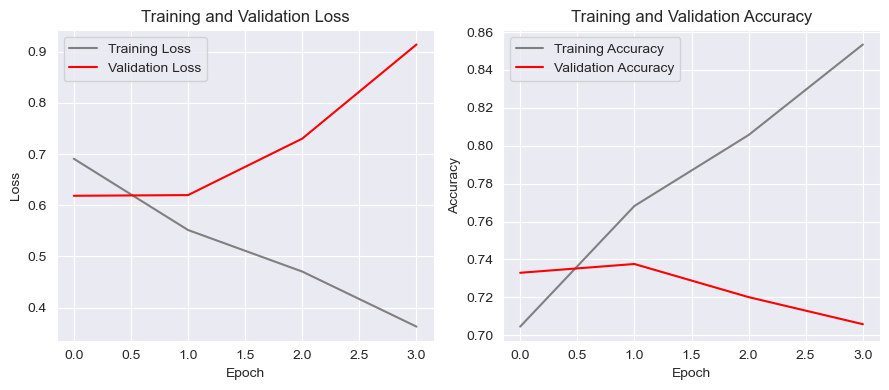

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['acc'], label='Training Accuracy')
axes[1].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

337/337 [==============================] - 75s 223ms/step - loss: 0.6230 - acc: 0.7323


[0.6230049729347229, 0.7322885990142822]